In [ ]:
#requirments
!pip install diffusers
!pip install torch
!pip install accelerate
import scipy
import os
# from diffusers import AudioLDM2Pipeline
# from diffusers.models import AutoencoderKL
# from diffusers import StableDiffusionPipeline
# from transformers import SpeechT5HifiGan
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
PATH = "/content/drive/My Drive"
from accelerate import Accelerator


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path_to_model = "/content/drive/My Drive/final_unet"
# from diffusers.models import AutoencoderKL
if torch.cuda.is_available():
  p_device = ('cuda')
else:
  p_device = ('cpu')

vae = torch.load("/content/drive/My Drive/vae",map_location=p_device,weights_only=False).eval()
vocoder = torch.load("/content/drive/My Drive/vocoder",map_location=p_device).eval()
scheduler = torch.load("/content/drive/My Drive/scheduler")
unet = torch.load("/content/drive/My Drive/final_unet").eval().to(p_device)
accelerator = Accelerator()
vae, vocoder, scheduler, unet = accelerator.prepare(vae, vocoder, scheduler, unet.half())

models = {
    "vae":vae,
    "vocoder":vocoder,
    "scheduler":scheduler,
    "unet": unet
    }


In [ ]:
unet.num_parameters()

265531016

In [ ]:
from diffusers import AudioLDM2Pipeline
import diffusers.pipelines.audioldm2.modeling_audioldm2 as A

In [ ]:
ynet = A.AudioLDM2UNet2DConditionModel(
    sample_size = 256,
    in_channels = 8,
    out_channels = 8,
    flip_sin_to_cos = True,
    freq_shift = 0,
    down_block_types= (
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
    ),
    mid_block_type = "UNetMidBlock2DCrossAttn",
    up_block_types = ("CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D","UpBlock2D"),
    only_cross_attention = False,
    block_out_channels= (128, 256, 384, 640),
    layers_per_block = 2,
    downsample_padding = 1,
    mid_block_scale_factor = 1,
    act_fn = "silu",
    norm_num_groups = 32,
    norm_eps = 1e-5,
    # cross_attention_dim = ([None,1024,64],[None,1024,64],[None,1024,64],[None,1024,64]),
    cross_attention_dim = [[None,1024],[None,1024],[None,1024],[None,1024]],
    # cross_attention_dim = [[None,64],[None,64],[None,64],[None,64]],
    transformer_layers_per_block = 1,
    attention_head_dim = 8,
    num_attention_heads = None,
    use_linear_projection = False,
    class_embed_type = None,
    num_class_embeds = None,
    upcast_attention = False,
    resnet_time_scale_shift= "default",
    time_embedding_type = "positional",
    time_embedding_dim = None,
    time_embedding_act_fn = None,
    timestep_post_act = None,
    time_cond_proj_dim = None,
    conv_in_kernel = 3,
    conv_out_kernel = 3,
    projection_class_embeddings_input_dim = None,
    class_embeddings_concat = False,
)



In [ ]:
repo_id = "cvssp/audioldm2-large"
pipe = AudioLDM2Pipeline.from_pretrained(repo_id, torch_dtype=torch.float16)
pipe.unet.num_parameters() - unet.num_parameters()

452481280

In [ ]:
repo_id = "cvssp/audioldm2-music"
pipe = AudioLDM2Pipeline.from_pretrained(repo_id, torch_dtype=torch.float16)
# pipe.unet.num_parameters() - unet.num_parameters()

Loading pipeline components...:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
# mpipe.unet.block_out_channels
pipe.to('cuda')
prompt = "child cry"
audio = pipe(prompt, num_inference_steps=200, audio_length_in_s=8.0).audios[0]
from IPython.display import Audio

Audio(audio, rate=16000)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
pipe.unet = pipe.unet.to(p_device)
ynet = ynet.to(p_device)
ynet.num_parameters()
i = 0
for lay in ynet.state_dict().keys():
  # i+= 1
  # print(lay,i)
  # i +=1
  if unet.state_dict()[lay].shape == pipe.unet.state_dict()[lay].shape:
    print(lay,i)
    i +=1
    unet.state_dict()[lay] = pipe.unet.state_dict()[lay]
torch.save(unet,"/content/drive/My Drive/final_unet")

In [ ]:
print(i)
print(len(list(ynet.state_dict().keys())))

1060
1104


In [ ]:
with torch.no_grad():
  tensor = torch.randn((8,1,1024,64),dtype=torch.float16,device = p_device)
  latents = models['vae'].encode(tensor).latent_dist.sample()* 0.18215
# latents = latents.type(torch.float32)
latents.dtype
latents.shape
# print(encoded.shape)

torch.Size([8, 8, 256, 16])

In [ ]:
# n = torch.randn((1,64,1024),dtype=torch.float32,device = p_device)
n = torch.randn((8,64,1024),dtype=torch.float16,device = p_device)
# n1 = torch.randn_like(encoded,dtype=torch.float32,device = p_device)
# diff_out = models['unet'](encoded.type(torch.float32),timestep = 1, encoder_hidden_states= n,return_dict=False)[0]

In [ ]:
import inspect
def prepare_extra_step_kwargs(generator, eta):
    # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
    # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
    # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
    # and should be between [0, 1]

    accepts_eta = "eta" in set(inspect.signature(models['scheduler'].step).parameters.keys())
    extra_step_kwargs = {}
    if accepts_eta:
        extra_step_kwargs["eta"] = eta

    # check if the scheduler accepts generator
    accepts_generator = "generator" in set(inspect.signature(models['scheduler'].step).parameters.keys())
    if accepts_generator:
        extra_step_kwargs["generator"] = generator
    return extra_step_kwargs
eta = 0.0
generator = torch.Generator(device='cuda')
extra_step_kwargs = prepare_extra_step_kwargs(generator , eta)

In [ ]:
num_inference_steps =200
scheduler.set_timesteps(num_inference_steps, 'cuda')
timesteps = scheduler.timesteps
print(timesteps)
num_warmup_steps = len(timesteps) - num_inference_steps * scheduler.order

for i, t in enumerate(timesteps):
  # print(i)
  # expand the latents if we are doing classifier free guidance
  # latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
  latent_model_input = latents
  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latents,timestep = t, encoder_hidden_states= n,return_dict=False)[0]
  latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

In [ ]:
# log_mels = models['vae'].decode(diff_out.type(torch.half))
log_mels = models['vae'].decode(latents.type(torch.float16))
print(log_mels.sample.shape)
print(torch.randint(
                0, 20, (8,),
                dtype=torch.int64
            ))


torch.Size([8, 1, 1024, 64])
tensor([ 2,  9,  6, 17, 18,  5,  2,  0])


In [ ]:
# Copied from diffusers.pipelines.audioldm.pipeline_audioldm.AudioLDMPipeline.mel_spectrogram_to_waveform
def mel_spectrogram_to_waveform(mel_spectrogram):
  if mel_spectrogram.dim() == 4:
      mel_spectrogram = mel_spectrogram.squeeze(1)
      print("was here")

  waveform = models['vocoder'](mel_spectrogram)
  # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
  waveform = waveform.cpu().float()
  print(waveform.shape)
  return waveform

In [ ]:
from IPython.display import Audio
original_waveform_length = 163872
# n = torch.randn((7,64,64),dtype=torch.float16).cuda()
# print(n.squeeze(0).shape)
audio = mel_spectrogram_to_waveform(log_mels.sample)
print(audio.shape)
# audio = mel_spectrogram_to_waveform()
audio = audio[:, :original_waveform_length].detach().numpy()
Audio(audio, rate=16000)

was here
torch.Size([1, 163872])
torch.Size([1, 163872])


extracting mel spec check

In [ ]:
!pip install librosa

[link text](https://)

In [ ]:
import numpy as np
import librosa

def extract_log_mel_spectrogram(audio, sr=16000, n_fft=1024, hop_length=160, n_mels=64,f_min=0, f_max=8000, win_length=1024):
    """
    Extracts the log Mel spectrogram from an audio signal.

    Parameters:
    - audio: numpy array, the audio signal.
    - sr: int, the sampling rate of the audio signal.
    - n_fft: int, the length of the FFT window.
    - hop_length: int, the number of samples between successive frames.
    - n_mels: int, the number of Mel bands.

    Returns:
    - log_mel_spectrogram: numpy array of shape (1, 1, 1024, 64), the log Mel spectrogram.
    """
    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=0, fmax=11025, win_length=1024,center=True)
    print(mel_spectrogram.shape)
    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

    # # Ensure the time dimension is 1024
    # # This might require adjusting hop_length or trimming/padding the spectrogram
    # target_time_frames = 1024
    # if log_mel_spectrogram.shape[1] > target_time_frames:
    #     log_mel_spectrogram = log_mel_spectrogram[:, :target_time_frames]  # Trim
    # elif log_mel_spectrogram.shape[1] < target_time_frames:
    #     # Pad with zeros to match the desired time dimension
    #     pad_width = target_time_frames - log_mel_spectrogram.shape[1]
    #     log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')

    # # Reshape to match the desired output shape (1, 1, 1024, 64)
    # # log_mel_spectrogram = log_mel_spectrogram[np.newaxis, np.newaxis, :, :]

    # return log_mel_spectrogram


In [ ]:
n_fft = 1024
hop_length = 160
win_length = 1024
n_mels = 64
target_sr = 22050
fmax = int(target_sr/2)
fmin = 0
audio_len_sec = 5
num_samples = int(audio_len_sec*target_sr)
target_length = 1024
try_num_samples = (target_length-1)*hop_length
print(try_num_samples)
target_length_sec = try_num_samples/target_sr
print(target_length_sec)
x = np.arange(64512).astype(float)
x,sr = librosa.load("/content/drive/MyDrive/music 2.wav")
if sr != target_sr:
  x_resampled = librosa.resample(x, orig_sr=sr, target_sr=target_sr)[:num_samples]
  x_try_resampled = librosa.resample(x, orig_sr=sr, target_sr=target_sr)[:try_num_samples]
else:
  x_resampled = x[:num_samples]
  x_try_resampled = x[:try_num_samples]
# x = x[:64512]
# print(x.shape)
# print(x_resampled.shape)
# print(sr)
# print(x.shape[0]/sr)

# x = 500*np.sin(freq1*x +np.random.randint(-3,3)) +1200*np.sin(freq2*x) + np.random.randint(-10,10,64512)
# spec = extract_log_mel_spectrogram(x_resampled, sr=target_sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,f_min=fmin, f_max=fmax, win_length=win_length)
spec_t = extract_log_mel_spectrogram(x_try_resampled, sr=target_sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,f_min=fmin, f_max=fmax, win_length=win_length)
# print(spec.shape)
# print(spec_t.shape)
# spec = spec.reshape(1024,64)
from IPython.display import Audio
# Audio(x,rate = sr)
Audio(x_resampled,rate = target_sr)


163680
7.42312925170068
(64, 1024)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

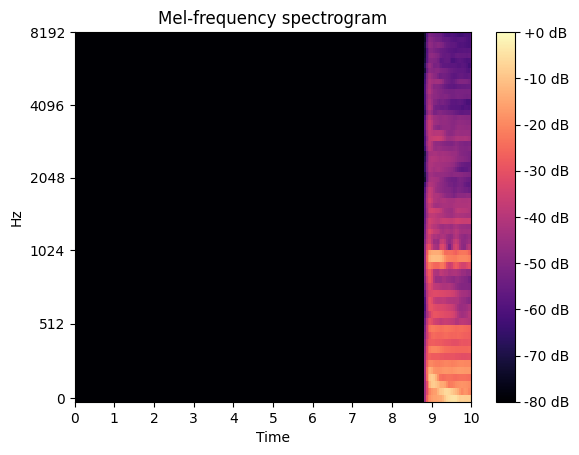

In [ ]:
(speimport matplotlib.pyplot as plt
fig, ax = plt.subplots()

# S_dB = librosa.power_to_db(S, ref=np.max)
S_dB = spec

ax.set_xlim(0,10)
img = librosa.display.specshow(data = S_dB,
                               y_axis= 'mel',
                               x_axis='time',
                                hop_length=hop_length,
                               sr=sr,
                              n_fft = n_fft,
                        #  x_coords = np.arange(1024)/sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

Loading the Dataset and the model

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()
path_to_unet = ""
path_to_vae = ""

dataset = DataSet()

unet = torch.load(path_to_unet)
vae = torch.load(path_to_vae)

In [ ]:
import torch
# train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

from PIL import Image
from diffusers import DDPMScheduler

SAMPLE_SHAPE = (1,1,1024,64) #SOMETHING LIKE THIS, DEPENDS ON THE TRACK LENGTH

# sample_track = dataset[0]["with_drums"].unsqueeze(0)
# print("Input shape:", sample_track.shape)

# print("Output shape:", unet(sample_track, timestep=0).sample.shape)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(SAMPLE_SHAPE)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(x, noise, timesteps)


tensor([50])

In [ ]:
import torch.nn.functional as F
from diffusers.optimization import get_cosine_schedule_with_warmup

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)